# HW4: Regression!

*Due Tuesday 7 November at 14:20 on Blackboard.*

Please just hand in this completed .ipynb file.

<font color="red">**IMPORTANT: Please name your file with your name(s). (e.g., "Mary_Isaac_HW3.ipynb")** </font> 

You may hand this in in pairs.  If you do, only one member of each pair needs to hand it in, just make it clear who your partner is.

## Overview

Recall the two previous HWs: 
* In HW2, we looked at the effect of a job training program on employment (and concluded that an RCT was the way to go...)
* In HW3, we looked at the effect of having children on whether or not a woman works, in the US and in Turkey.

Previously, we did this just by comparing means, and we hoped that because there was something random going on (an explicit RCT in HW2; or the same-sex vs different-sex instrument in HW3), we were actually getting at a causal relationship.

In this HW, you'll revisit HW2 and HW3 with our new tool, **regression**!

**I collaborated with Umut on this HW**

# Part A: Job training program

This is the same data that we used in HW2 (go back to HW2 for more details about it).

## Part A1: Load the data.

Run the following cells to load the data.

**New Python Trick!** In this HW, we'll introduce a few new packages, like Pandas and StatsModels.  If you installed Python/Jupyter notebooks using Anaconda, you should already have these packages.  If you installed using pip, you may or may not have them, but if you don't, you can get them with "pip install pandas" and "pip install statsmodels" on the command line.

**Note:** Be careful about user-friendly packages (like the ones we'll be using) that do lots of things for you!  You really want to make sure you know what they are doing!  If this were a more programming-intensive course, we'd make you implement all of these things from scratch in Python -- if you want a good exercise and you have some background knowledge, try to do that! :)

In [2]:
# Import all of our favorite packages...
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from matplotlib import pyplot as plt
import csv

# same deal as in previous assignments: load the csv file
datafile = open('jobtraining.csv', newline='')
dataDict = csv.DictReader(datafile, delimiter=",")

# Turn this into a pandas dataframe, and cast the values as numeric
dataPd = pd.DataFrame(dataDict)
for var in dataDict.fieldnames:
    dataPd[var] = pd.to_numeric(dataPd[var], errors='coerce')


print("Great! Data is loaded")

Great! Data is loaded


In [3]:
# We can print out the data set to see a few rows and also the field names.
dataPd

,treat,control,nexp1,nexp2,age,education,Black,Hispanic,married,nodegree,earnings_1975,earnings_1978
0,0,1,0,0,23,10,1,0,0,1,0.000,0.00
1,0,1,0,0,26,12,0,0,0,0,0.000,12383.68
2,0,1,0,0,22,9,1,0,0,1,0.000,0.00
3,0,1,0,0,34,9,1,0,0,1,4368.413,14051.16
4,0,1,0,0,18,9,1,0,0,1,0.000,10740.08
...,...,...,...,...,...,...,...,...,...,...,...,...
3335,0,0,0,1,46,12,0,0,0,0,23918.730,12532.26
3336,0,0,0,1,26,16,0,0,0,0,24490.840,27750.00
3337,0,0,0,1,48,8,0,0,1,1,25470.470,0.00
3338,0,0,0,1,50,12,0,0,1,0,26254.180,0.00


**Remember that here's what each of these variables mean:**
* treat: 1 if the subject was in the treatment group of the RCT, 0 otherwise
* control: 1 if the subject was in the control group of the RCT, 0 otherwise
* nexp1: 1 if the subject was not part of the NSW program, but was included in the first "non-experimental" control group.  (And 0 otherwise).
* nexp2: Same as nexp1 but for the second "non-experimental" control group.
* age: subject's age in 1975
* education: years of education (as of 1975)
* Black: 1 if the subject is Black, 0 otherwise
* Hispanic: 1 if the subject is Hispanic, 0 otherwise
* married: 1 if the subject was married in 1975
* nodegree: 1 if the subject did *not* receive a high school degree (as of 1975) 
* earnings_1975: earnings (in dollars) in 1975 (Adjusted for inflation to 1982 dollars)
* earnings_1978: earnings (in dollars) in 1978 (Adjusted for inflation to 1982 dollars)


Below, we'll want to split out the experimental sample.  Run the code below to do that.

In [4]:
# This picks out the rows where either "treat" or "control" is equal to 1.
expSample = dataPd.loc[dataPd['treat'] + dataPd['control'] == 1]
expSample

,treat,control,nexp1,nexp2,age,education,Black,Hispanic,married,nodegree,earnings_1975,earnings_1978
0,0,1,0,0,23,10,1,0,0,1,0.000,0.000
1,0,1,0,0,26,12,0,0,0,0,0.000,12383.680
2,0,1,0,0,22,9,1,0,0,1,0.000,0.000
3,0,1,0,0,34,9,1,0,0,1,4368.413,14051.160
4,0,1,0,0,18,9,1,0,0,1,0.000,10740.080
...,...,...,...,...,...,...,...,...,...,...,...,...
717,1,0,0,0,20,9,1,0,0,1,0.000,8881.665
718,1,0,0,0,31,4,1,0,0,1,4023.211,7382.549
719,1,0,0,0,24,10,1,0,1,1,4078.152,0.000
720,1,0,0,0,33,11,1,0,1,1,25142.240,4181.942


## Part A2: Our first regression!

In this part, we'll run a regression for just the experimental sample.  We'll fit a simple linear model of the form: [1978_earnings] = a + b[treat].

That is, we want to estimate the "best" values of a and b so that the above equation is as close to being satisfied as possible.

Run the following code to do this.  Here are what the arguments to the ols function mean:
* The first argument "earnings_1978 ~ treat" describes the model we are trying to fit.  It says that we want to explain the variable "earnings_1978" in terms of the variable "treat."  We'll see later that if we want to explain some variable Y in terms of multiple other variables, we'd use a plus sign, like "earnings_1978 ~ treat + age".
* The second argument, expSample, is our dataset
* The third argument, missing="drop", is optional, and tells Python what to do with data that have missing observations.  In this case, we're telling it to drop those data points.

In [5]:
model = ols("earnings_1978 ~ treat", expSample, missing="drop").fit()
model.params #Intercept = a, treat = b (coefficent of treat)

Intercept    5090.048302
treat         886.303731
dtype: float64

Above, you should have gotten a value for "Intercept" and value for "treat".  The "Intercept" is the best estimate for "a" above; it's the y-intercept of the line.  The "treat" is the best estimate for "b" above; it's the coefficient on the "treatment" variable.

You can get more information about the regression by running the following command.  It tells you thinks like "R-squared", "standard errors", and "p-values", which quantify how good a fit this linear model is.

We're not going to go into the details of how these are computed and what they mean, but here are some rules of thumb:

## Rules of Thumb for Deciding if Regression Results are "Important."
* **Look at the "std err" column for each coefficient.**  If a coefficient's standard error is small relative to its value, then the estimate is precise. If the standard error is large relative to its value, then the estimate is not precise.  
* **Look at the "p-value" in the column labeled "P > |t|".**  This translates the standard error into a statement about how surprised you should be.  It tells you the probability of seeing a coefficient that is this large in magnitude by chance.  Loosely, if we were to generate random samples from the same population, then how often would we get a coefficient of this size just by chance.  If this is very small (a "standard" threshold is less than 0.05), then we think that the relationship captured by that coefficient is "statistically significant," aka, that it's a real effect, and not one that just showed up by random chance.  If this p-value is large, then we probably shouldn't read too much into the relationship captured by this coefficient. Note that if you look at 20 coefficients then even if there is nothing going on you should expect to be surprised by 1 of them!
* **Look at the "R-squared" that appears at the top.**  This number tells us the share of the variance that is "explained" by the regressors.  If it is very close to zero, this means that most of the variance is *not* explained by the regression model, so we don't think that these factors do a good job of predicting/explaining the outcome.  If it is very close to 1, this means that most of the variance *is* predicted/explained by the regression model, so we do think that these factors do a good job of predicting/explaining the outcome.

In [6]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          earnings_1978   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.525
Date:                Tue, 07 Nov 2023   Prob (F-statistic):             0.0609
Time:                        11:39:16   Log-Likelihood:                -7333.1
No. Observations:                 722   AIC:                         1.467e+04
Df Residuals:                     720   BIC:                         1.468e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5090.0483    302.783     16.811      0.0

As we learned in class, a regression of this form is just finding a line of best fit.  Let's plot that and see what it looks like!

In [7]:
a = model.params["Intercept"]
b = model.params["treat"]
x = expSample["treat"]
y = expSample["earnings_1978"]
linearX = [x/10 for x in range(-1,12)]
linearY = [a + b*x for x in linearX]

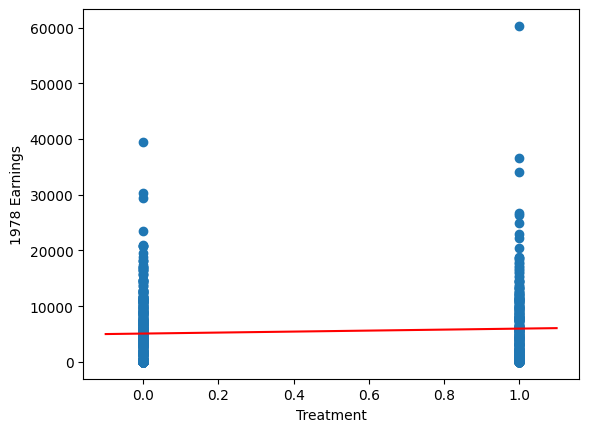

In [8]:
plt.scatter(np.array(x),np.array(y))
plt.xlabel("Treatment")
plt.ylabel("1978 Earnings")
plt.plot(linearX, linearY,color="red")
plt.show()

## <font color="red">Interpretation time!</font>

<font color="red"> Explain how the regression we just did relates to the RCT that the data come from. How should we interpret a and b, both in words and also in terms of jargon/notation we've already learned *before* Class 5?
    
<font color="red">**TODO:** Double-click the box below and enter your answer. </font>

**ANSWER:**
$b$ is observational comparison. Since we run RCT, the observational comparison is equal to the average treatment effect. Thus, $b$ is ATE. <br>
$a$ is the baseline average earnings of control group. People who are not in the treatment group would have $a$ earnings in average
<br>
We can also say that treatment has significant effect on 1978 earnigs by looking at the $P>|t|$ value in the regression table. It is closer to the "standard" threshold (0.05) which indicates its statistical significance.<br>

$Y_j = a + bD_j$ <br>
$Y_j$: earnings of jth person <br>
$D_j$: 1 if treated, 0 otherwise <br>
$b$: returns to treatment, ATE (in this case) <br>
$a$: average earnings of control group, independent from $x_j$ and $b$

## Part A3: Adding more variables

Now we can throw a few more variables into the model.  More precisely, let's fit a model of the form:

[earnings_1978] = a + b[treat] + c[age] + d[education] + ... + z[earnings_1975]

(that is, we'll throw in all of the variables!)

Run the following cell to do that.

In [9]:
model = ols("earnings_1978 ~ treat + age + education + Black + Hispanic + married + nodegree + earnings_1975", expSample, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          earnings_1978   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.966
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           0.000131
Time:                        11:39:16   Log-Likelihood:                -7319.1
No. Observations:                 722   AIC:                         1.466e+04
Df Residuals:                     713   BIC:                         1.470e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3879.6043   2604.433      1.490

As before, you should get a number in the "coef" column for "Intercept" -- that's the "a" in our equation -- and similarly coefficients on each of the other variables in our linear model.  You'll also get a lot of other information.  It's okay to ignore this for now since we haven't talked about what it all means, but take a look at them in light of the "rules of thumb" mentioned above.

## <font color="red">Interpretation time!</font>

<font color="red"> How should we interpret these numbers?  In particular, answer the following questions. (A sentence or two each is fine).</font>

   1. How would you interpret the number on "treat"?  Would you interpret this the same way or differently as the number in our first regression?  Why or why not?  (In particular, is this number close to or far from the number that we got in the first regression?  Does that make sense?)
   2. How would you interpret the number on, say "education," or "Black"?  Do you interpret those numbers the same way you interpret the number on "treat"?  Why or why not?
    
<font color="red">**TODO:** Double-click the box below and enter your answer. </font>

**ANSWER**: TODO
$Y_j = a + bD_j$ + $\sum_{i=1}^{d}c^{(i)} X_j^{(i)}$
1. The value of "treat" is smaller as the number of observables increases. Also, the correlation between treat and intercept has less statistical significance due to the increase in P > |t| value of treat. There could be several reasons for this. As the complexity of the model increases, it becomes harder to evaluate the real effect of treatment. The observables and unobservables may act as confounding variables. Moreover, the multicollinearity might affect the "treat" value. Therefore, the "treat" value is less representative of the treatment effect than the previous. It is expected to obtain a different value in this regression<br>

2. Even though number on "Black" is more than than "treat", I would not interpret this value as the effect of being black on earnings. Looking at observables such as "Black" and "education" might mislead us in terms of establishing causality, since they can act as confounding variables. We need to construct another experiment with different control/treatment groups to assess the effect of such variables on earnings as we created control and treatment groups based on program attendance.

## Part A4: Using the non-experimental "control" group.

Recall that in HW2, there was an experimental group that we looked at above, where we had a treatment and control group from an RCT.  There was also a non-experimental "control" group that researchers tried to construct from separate observational data.  Let's make a data set with the real (experimental) treatment group, and the non-experimental "control" group.

In [10]:
withNonExpControl = dataPd.loc[dataPd['treat'] + dataPd['nexp2'] == 1]

Next, let's run a regression to fit a model of the form:

[treat] = a + b*[age] + c*[education] + ...

That is, we are thinking about selection into the *treatment* group as the output variable, and we are wondering what observables predict that.  Run the following cell to do that regression.

In [11]:
model = ols("treat ~ age + education + Black + Hispanic + married + nodegree + earnings_1975", withNonExpControl, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  treat   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     51.36
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.44e-52
Time:                        11:39:17   Log-Likelihood:                -139.77
No. Observations:                 425   AIC:                             295.5
Df Residuals:                     417   BIC:                             328.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7691      0.175      4.392

## <font color="red">Interpretation time!</font>

<font color="red"> How should we interpret these numbers?  In particular, answer the following questions.  (A sentence or two each is fine).</font>

   1. Which variables seem like they might be important for determining who is in the treatment group? Why?
   2. What does your answer to question 1 tell you about whether or not we need to worry about selection effects? 
   
<font color="red">**TODO:** Double-click the box below and enter your answer. </font>

**ANSWER**: 

1. By looking at the P > |t| values within the regression table, we might say that variables except for education, earnings_1975, and Hispanic are important for determining who is in the treatment group. Therefore, I think the determining variables might be married, age, black, and nodegree. Compared to other variables, we might also say that black, married, and nodegree variables have a more significant effect on the dependent variable.
2. Due to the observable matching, there is a considerable bias in the determination of the treatment group. We need to worry about selection effects if we will use this control group. 

## Part A5.  Repeating A2 with the non-experimental "control" group.

Recall that in HW2, when we did the observational comparison with the non-experimental "control" group, we got something that was pretty different than the observational comparison with the experimental control group.  Let's do the same thing with regression:

In [12]:
model = ols("earnings_1978 ~ treat", withNonExpControl, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          earnings_1978   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     23.64
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.64e-06
Time:                        11:39:17   Log-Likelihood:                -4336.4
No. Observations:                 425   AIC:                             8677.
Df Residuals:                     423   BIC:                             8685.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2610.6959    578.718      4.511      0.0

## <font color="red">Interpretation time!</font>

<font color="red"> How does the coefficient on "treat" compare to what you got in Part A2?  How do you interpret that difference?</font>

   
<font color="red">**TODO:** Double-click the box below and enter your answer. </font>

**ANSWER:** It seems that the "treat" value is greater than the one in Part A2. Using non-experimental control group resulted in an overestimation of ATE due to the effect of confounding variables. The regression results also indicate that there is very strong correlation between treatment and earnings_1978, which is expected because researchers obtained the best match of observables. However, observable matching creates selection effects which might mislead us in terms of causality.

# Part A6.  Can regression help us "control" for the selection effects?

In part A4 you may have identified some possible confounding variables (e.g., that may be responsible for selection effects).  And in part A5 you may have seen that indeed there was a big discrepancy that these confounding variables may be responsible for.  (If you didn't see these things...maybe go back and double-check your work :) ).

To that end, we might try to use regression to *control* for those variables that we think might be confounders.

Write code below to run a regression with earnings_1978 as the dependent variable, "treat" as one of the independent variables, on the withNonExpControl dataset, **and** where you control on some variables that you are worried about.  Do you get an effect that's closer to what you got from the RCT?  (e.g., the effect from parts A2 and A3?)

**Hint:** Use the previous examples of code as a template.

## <font color="red"> Coding time! </font>

<font color="red"> Write code to do this below. Two lines should be enough. </font>

In [18]:
model = ols("earnings_1978 ~ treat + age + Black + married + nodegree", withNonExpControl, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          earnings_1978   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     6.329
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.11e-05
Time:                        11:54:04   Log-Likelihood:                -4332.5
No. Observations:                 425   AIC:                             8677.
Df Residuals:                     419   BIC:                             8701.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3450.7399   1522.939      2.266      0.0

## <font color="red">Interpretation time!</font>

<font color="red"> What did you get? Do you think that using regression to help "control" for possible confounders can fix the issue and help you establish causality in the absence of an RCT?</font>


<font color="red">**TODO:** Double-click the box below and enter your answer. </font>

**ANSWER:** When taking the black, age, married, and nodegree variables into account, the treatment effect on earnings increases. As mentioned in A4, black, age, married, and nodegree variables might act as confounding variables, leading to selection effects. We might also consider evaluating the effect of confounding variables separately, to understand their individual impact on the dependent variable. Moreover, we can see that P > |t| values are above threshold which is good. Overall, regression helps us to re-evaluate causality by controlling for confounding variables in the absence of an RCT. But RCT is better :)

# Part B: The effect of children on women's labor force participation

Next, we'll move on to our example from HW3.

**Recall** that the idea here is that someone is in the "treatment" group if their first two children had the same sex, because that means that they are (hopefully randomly...) slightly more likely to have a third child.  Othewise they are in the "control" group.

Run the cell below to load the data.

**NOTE:** This data set is slightly different than the one from HW3: we removed all of the women with <2 children, so that the code runs a bit faster.  It shouldn't affect anything (unless you did some extra credit), since the main assignment never looked at those women.

## Part B1: Load the Data

In [14]:
# same deal as in previous assignments: load the csv file
datafile = open('childrenwork_reduced.csv', newline='')
dataDict = csv.DictReader(datafile, delimiter=",")

# Turn this into a pandas dataframe
print("Please wait...")
dataPd = pd.DataFrame(dataDict)

print("Great! Data is loaded!")

Please wait...
Great! Data is loaded!


Recall from HW3 that here is what the variables mean. (Everything is calculated at the time of the survey, which was in the year 2000.)

**Here are the most important ones for our purposes:**

* country: either "Turkey" or "USA"
* empstat: mother is currently employed (aka, 1 if she is employed, 0 otherwise)
* three_or_more: equals 1 if there are three or more children, 0 otherwise
* same_sex: equals 1 if first and second child have the same gender, 0 if different gender, and blank if <2 children.
* nchild: number of children at the time of the survey

**NOTE:** If a women doesn't have two or more children, then the "same_sex" variable will be blank.  (We will set it to the Python primitive None below).

**And here are a bunch of other variables that might be interesting to look at!**

* age: age of the mother
* age1-age6: age of the 1st through 6th child in the data
* education: mother’s years of education at the time of the survey
* low_educ: an indicator for whether the mother has “low” education (the bottom 70% of education in Turkey, and the bottom 73% in the U.S.; in Turkey this is 5 years or less, in the U.S. this is 13 years or less)
* married: mother is married
* marr_divorce: mother is divorced
* marr_separate: mother is separated
* marr_single: mother is single
* marr_widow:  mother is a widow
* sex1-sex6: sex of the first 6 children  (In the original data, "1"=male; "2"=female; below we'll change that to "F" and "M" so we don't forget)
* spouse_age: age of spouse
* spouse_education: spouse years of education
* spouse_empstat: spouse is employed (1=employed; 0= not employed)
* two_boys: first two children are boys
* two_girls: first two children are girls 
* two_or_more: equals 1 if there are two or more children, 0 otherwise

### Some data-wrangling

Run the following two cells to cast the things that should be numeric to be numeric, and then to split this dataset into US and Turkey datasets.

In [15]:
should_be_numeric = ["age", "age1", "age2", "age3", "age4", "age5", "age6", "empstat", "low_educ", "married", "marr_divorce", "marr_separate", "marr_single", "marr_widow", "nchild", "same_sex", "spouse_age", "spouse_empstat", "three_or_more", "two_boys", "two_girls", "two_or_more", "education", "spouse_education"]

In [16]:
print("Please wait...")
for var in should_be_numeric:
        dataPd[var] = pd.to_numeric(dataPd[var], errors='coerce')

dataUS = dataPd.loc[dataPd["country"]=="USA"]
dataTurkey = dataPd.loc[dataPd["country"]=="Turkey"]
print("done!")

Please wait...
done!


In [17]:
# Take a quick look at the US data:
dataUS

,sex1,age1,sex2,age2,sex3,age3,sex4,age4,sex5,age5,...,marr_separate,marr_single,marr_widow,same_sex,two_boys,two_girls,country,two_or_more,three_or_more,low_educ
194411,1,6,2,3,1,2.0,,NaN,,NaN,...,0.0,0.0,0.0,0,0,0,USA,1,1,0
194412,2,7,1,6,,NaN,,NaN,,NaN,...,0.0,0.0,0.0,0,0,0,USA,1,0,0
194413,2,7,1,6,,NaN,,NaN,,NaN,...,0.0,0.0,0.0,0,0,0,USA,1,0,0
194414,1,6,2,3,1,1.0,,NaN,,NaN,...,0.0,0.0,0.0,0,0,0,USA,1,1,0
194415,2,7,1,5,2,1.0,,NaN,,NaN,...,0.0,0.0,0.0,0,0,0,USA,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672873,2,7,2,5,,NaN,,NaN,,NaN,...,0.0,0.0,0.0,1,0,1,USA,1,0,1
672874,1,13,1,9,,NaN,,NaN,,NaN,...,0.0,0.0,0.0,1,1,0,USA,1,0,1
672875,1,12,1,6,,NaN,,NaN,,NaN,...,0.0,0.0,0.0,1,1,0,USA,1,0,1
672876,2,8,2,7,,NaN,,NaN,,NaN,...,0.0,0.0,0.0,1,0,1,USA,1,0,1


In [18]:
# And a quick look at the Turkish data:
dataTurkey

,sex1,age1,sex2,age2,sex3,age3,sex4,age4,sex5,age5,...,marr_separate,marr_single,marr_widow,same_sex,two_boys,two_girls,country,two_or_more,three_or_more,low_educ
0,1,15,2,13,1,11.0,2,10.0,1,9.0,...,NaN,0.0,0.0,0,0,0,Turkey,1,1,0
1,2,9,1,7,2,4.0,1,0.0,,NaN,...,NaN,0.0,0.0,0,0,0,Turkey,1,1,0
2,1,2,2,0,,NaN,,NaN,,NaN,...,NaN,0.0,0.0,0,0,0,Turkey,1,0,0
3,1,15,2,10,1,3.0,,NaN,,NaN,...,NaN,0.0,0.0,0,0,0,Turkey,1,1,0
4,2,13,1,11,1,8.0,1,0.0,,NaN,...,NaN,0.0,0.0,0,0,0,Turkey,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194406,2,13,2,10,1,1.0,,NaN,,NaN,...,NaN,0.0,0.0,1,0,1,Turkey,1,1,1
194407,1,10,1,8,1,5.0,,NaN,,NaN,...,NaN,0.0,0.0,1,1,0,Turkey,1,1,1
194408,1,11,1,7,,NaN,,NaN,,NaN,...,NaN,0.0,0.0,1,1,0,Turkey,1,0,1
194409,1,10,1,6,,NaN,,NaN,,NaN,...,NaN,0.0,0.0,1,1,0,Turkey,1,0,1


## Part B2:  A few regressions...

First, we're going to run **two** regressions (actually four, two in each of the US and Turkey).  We're not going to tell you what they mean, that will be your job...

In [19]:
# Regression 1:

modelUS = ols("three_or_more ~ same_sex", dataUS,missing="drop").fit()
print(modelUS.summary())
thing1_US = modelUS.params["same_sex"]

print("===========")

modelTk = ols("three_or_more ~ same_sex", dataTurkey,missing="drop").fit()
print(modelTk.summary())
thing1_Tk = modelTk.params["same_sex"]

                            OLS Regression Results                            
Dep. Variable:          three_or_more   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1132.
Date:                Mon, 06 Nov 2023   Prob (F-statistic):          8.68e-248
Time:                        17:52:25   Log-Likelihood:            -3.3161e+05
No. Observations:              478467   AIC:                         6.632e+05
Df Residuals:                  478465   BIC:                         6.632e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3525      0.001    354.269      0.0

In [20]:
# Regression 2:

modelUS = ols("empstat ~ same_sex", dataUS,missing="drop").fit()
print(modelUS.summary())
thing2_US = modelUS.params["same_sex"]

print("===========")

modelTk = ols("empstat ~ same_sex", dataTurkey).fit()
print(modelTk.summary())
thing2_Tk = modelTk.params["same_sex"]

                            OLS Regression Results                            
Dep. Variable:                empstat   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.621
Date:                Mon, 06 Nov 2023   Prob (F-statistic):             0.0177
Time:                        17:52:26   Log-Likelihood:            -3.4129e+05
No. Observations:              478467   AIC:                         6.826e+05
Df Residuals:                  478465   BIC:                         6.826e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5802      0.001    571.373      0.0

In [21]:
# Combining them...
thing3_US = thing2_US/thing1_US
print("US:")
print("thing1:\t", thing1_US)
print("thing2:\t", thing2_US)
print("thing3:\t", thing3_US)

thing3_Tk = thing2_Tk/thing1_Tk
print("Turkey:")
print("thing1:\t", thing1_Tk)
print("thing2:\t", thing2_Tk)
print("thing3:\t", thing3_Tk)

US:
thing1:	 0.047069438167156016
thing2:	 -0.0033852108143431325
thing3:	 -0.07191950756500118
Turkey:
thing1:	 0.06706980065468926
thing2:	 -0.0009181573768836278
thing3:	 -0.013689579630790713


## <font color="red">Interpretation time!</font>

<font color="red"> Answer the following questions with a sentence or two each.  (Hint: This is related to HW3...) </font>

1. How should we interpret thing1?
2. How should we interpret thing2?
3. How should we interpret thing3?

<font color="red">**TODO:** Double-click the box below and enter your answer. </font>

**ANSWER:** 
<br>
$Z_j$ = same_sex <br>
$D_j$ = three_or_more <br>
$Y_j$ = emp_status <br>
1. thing1 is the coefficient of the independent variable same_sex (Zj). The dependent variable is three_or_more (Dj). The coefficient indicates the effect of the independent variable on the dependent variable. Therefore, thing1 is the effect of having the first two children of the same sex on the likelihood of having three or more children. This effect appears to be more significant in Turkey compared to the US. We can see that the statistical relationship between the dependent and the independent variable is significant by looking at the P > |t| value.  
<br><br>
2. thing2 is the coefficient of same_sex (Zj). The dependent variable of the regression module is emp_status (Yj). The coefficient indicates the effect of the independent variable on the dependent variable. Therefore, thing2 is the effect of having the first two children of the same sex on women's employment status. This effect appears to be more significant in Turkey compared to the US. 
<br><br>
3.  As we did in HW3, thing3 is the value of the average treatment effect among the compliers, aka the Local Average Treatment Effect. Compared to Turkey, US women are more likely to leave their jobs as they have more children.

## Part B3:  Are there selection effects?

Just like in Part A4, we can look at what observables, if any, seem related to being "in the treatment group."  In this case, being in the treatment group means having first two children of the same sex.

Below, we chose a few variables, but feel free to choose different ones and play around with it!

In [22]:
modelUS = ols("same_sex ~ age + education + married", dataUS, missing="drop").fit()
print(modelUS.summary())

modelTk = ols("same_sex ~ age + education + married", dataTurkey, missing="drop").fit()
print(modelTk.summary())

                            OLS Regression Results                            
Dep. Variable:               same_sex   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8179
Date:                Mon, 06 Nov 2023   Prob (F-statistic):              0.484
Time:                        17:52:32   Log-Likelihood:            -3.4723e+05
No. Observations:              478467   AIC:                         6.945e+05
Df Residuals:                  478463   BIC:                         6.945e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5123      0.006     84.395      0.0

## <font color="red">Interpretation time!</font>

<font color="red"> What do you think?  Are there "selection effects" we should worry about? Are there any observables that predict whether or not a woman will be in the treatment group?  </font>

<font color="violet"> **OPTIONAL:** Feel free to play around with different variables in the regression, or investigate leads further! </font>

<font color="red">How does your answer make you feel about the validity of our instrumental variable for establishing causal effects?</font>

**WARNING:** If you play around with the variables, not that if you run a regression with a covariate like "spouse_age", which is missing *unless* the person is married, then Python will drop all of the entries where that covariate is missing.  In particular, in that case Python will drop all of the unmarried women, so if you then try to also throw in the covariate "married," you might get something silly. 

<font color="red">**TODO:** Double-click the box below and enter your answer. </font>

**ANSWER:** <br>
I think we should not worry about selection effects. Because the effects of the selected independent variables on the dependent variable are negligible.
Since we do not see any selection effects, I think the instrumental variable did an excellent job of creating a randomized control and treatment group. Using these groups we can accurately estimate the average treatment effect.  

## OPTIONAL Part B4: Does controlling on other variables in part B2 make a difference?

Play around with the regressions from part B2.  Try controlling for other variables as well.  Does that make a difference?

In [ ]:
# OPTIONAL TODO: Your code for part B4 goes here.

### <font color="violet">OPTIONAL TODO:</font> 

Double-click this box and interpret your answers for (optional) part B4 here.

**ANSWER/Interpretation:** TODO (optional) 

